# Cartes du niveau de bruit sismique

In [1]:
%matplotlib inline

import datetime
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import warnings

from obspy import UTCDateTime, read_inventory
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

from mpl_toolkits.basemap import Basemap

%load_ext autoreload
%autoreload 2
from seismic_noise import *
import seismosocialdistancing

In [2]:
def add_subplot_axes(ax,rect):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    #subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    # subax.xaxis.set_tick_params(labelsize=x_labelsize)
    # subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

---
## Paramètre initiaux

In [3]:
PPSD_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/PPSD"
DRMS_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/DRMS"
MSEED_FOLDER = "/media/flavien/Flavien USB/Stages/noise_data/MSEED"
DATA_FOLDER  = "DATA"
freqs = [(0.01, 0.03), (0.1, 0.25), (0.3, 1), (1, 3), (5, 15), (20, 50)] # Bandes de fréquences à étudier
freq = "5.0-15.0"
freq_str = "5.0-15.0"

tStart = "2020-01-01"
tEnd   = "2021-08-01"

st_file = "DATA/st_metadata/stations_fr.xml"

# list_stations = ["FR.STR.00.HHZ", "FR.CURIE.00.HHZ", "FR.BRGF.00.HHZ"]
list_stations = np.loadtxt(DATA_FOLDER + "/st_metadata/stations_fr.txt", dtype=str)
# list_stations = ["FR.ABJF.00.HHZ"]

In [4]:
tags = {
    "2020-03-17": "Lockdown 1",
    "2020-05-11": "End lockdown",
    "2020-10-30": "Lockdown 2",
    "2020-12-15": "End lockdown + Curfew 20h",
    "2020-12-25": "Christmas",
    "2021-01-01": "New Year",
    "2021-01-16": "Curfew 18h",
    "2021-03-20": "Curfew 19h",
    "2021-04-03": "Lockdown 3",
    "2021-05-03": "End of certificate",
    "2021-05-19": "Curfew 21h + Shops open",
    "2021-06-09": "Curfew 23h + Restaurants open",
    "2021-06-30": "End Curfew"
}
dates_tags = pd.to_datetime(([key for key in tags.keys()]))
desc_tags = [(value) for value in tags.values()]

In [5]:
ref_per = (pd.Timestamp("2020-01-01"), pd.Timestamp("2020-03-01"))
list_per = {
    "per1": ( pd.Timestamp("2020-03-17"),pd.Timestamp("2020-05-11") ),
    "per2": ( pd.Timestamp("2020-10-30"),pd.Timestamp("2020-12-15") ),
    "per3": ( pd.Timestamp("2021-04-03"),pd.Timestamp("2021-05-03") )
}

desc = ["LOCKDOWN 1", "LOCKDOWN 2", "LOCKDOWN 3"]

In [6]:
maps_data = {}

for key, val in list_per.items():
    maps_data[key] = {"st_refmed":[], "st_permed":[], "st_var":[]}

maps_data

{'per1': {'st_refmed': [], 'st_permed': [], 'st_var': []},
 'per2': {'st_refmed': [], 'st_permed': [], 'st_var': []},
 'per3': {'st_refmed': [], 'st_permed': [], 'st_var': []}}

---
# Récupération des données

In [7]:
tStart = pd.Timestamp(tStart)
tEnd = pd.Timestamp(tEnd)
nDays = (tEnd - tStart).days
dates = pd.date_range(tStart, periods=nDays, freq="D")
dfDates = pd.DataFrame(index=dates)

In [8]:
for key, val in tqdm.tqdm(list_per.items()):

    med_values = []
    st_list = []

    st_refmed = []
    st_permed = []
    st_var    = []

    for j, st_str in enumerate(list_stations):
        # name = "{}_{}_{}".format(st_str, str(periods[i][0])[:10], str(periods[i][1])[:10])

        ### Calcul du déplacement RMS de la station
        try:
            dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
            dataframe.index = pd.to_datetime(dataframe.index)
            dRMS = dataframe.copy()
        except:

            st_refmed.append(np.nan)
            st_permed.append(np.nan)
            st_var.append(np.nan)

            continue

        ### Conversion heures locales
        dRMS = dRMS.copy().tz_localize("UTC").tz_convert("Europe/Brussels").tz_localize(None).resample("30Min").mean()

        st_list = np.append(st_list, st_str)    

        ### On garde les données dans la période temporelle qui nous intéresse
        mask_time = (dRMS.index > tStart) & (dRMS.index <= tEnd)
        dRMS = dRMS.loc[mask_time]

        dRMS_ref = dRMS.loc[(dRMS.index > ref_per[0]) & (dRMS.index <= ref_per[1])]
        dRMS_per = dRMS.loc[(dRMS.index > list_per[key][0]) & (dRMS.index <= list_per[key][1])]
        # dRMS = dRMS.copy().tz_localize("UTC").dropna().tz_convert("Europe/Brussels").tz_localize(None).resample("30Min").mean()

        ### Récupération du bruit
        dRMS_med = dRMS[freq].between_time("6:00", "16:00").resample("1D").median()
        dRMS_med = dfDates.join(dRMS_med, how='outer')

        dRMS_ref = dRMS_ref[freq].between_time("6:00", "16:00").resample("1D").median()
        dRMS_ref = dfDates.join(dRMS_ref, how='outer')

        dRMS_per = dRMS_per[freq].between_time("6:00", "16:00").resample("1D").median()
        dRMS_per = dfDates.join(dRMS_per, how='outer')

        ref_median = np.nanmedian(dRMS_ref)
        per_median = np.nanmedian(dRMS_per)
        noise_var = (per_median - ref_median) / ref_median * 100

        st_refmed.append(ref_median)
        st_permed.append(per_median)
        st_var.append(noise_var)

    maps_data[key]["st_refmed"] = st_refmed
    maps_data[key]["st_permed"] = st_permed
    maps_data[key]["st_var"] = st_var
    

  0%|                                                                                             | 0/3 [00:00<?, ?it/s]/home/flavien/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:32<00:00, 10.76s/it]


In [9]:
print(maps_data["per1"]["st_var"][5], maps_data["per2"]["st_var"][5], maps_data["per3"]["st_var"][5])

-14.1704727913 -2.02023253106 -2.7332675415


-18.5647990977
1.95965112782
2.87526359077


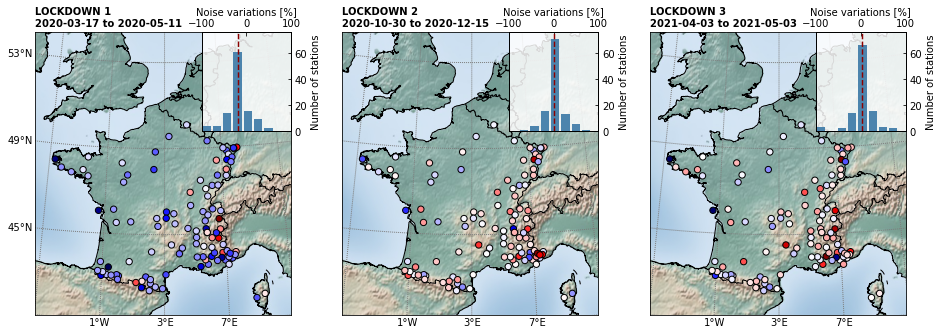

In [10]:
plt.figure(figsize=(15.6, 5.2))
N = 3

for k, key in enumerate(maps_data.keys()):
    
    ax = plt.subplot(1,N,k+1)
    
    c_var = maps_data[key]["st_var"]
    # c_var = [-200 if not (x<=0 or x>=0) else x for x in maps_data[key]["st_var"]]

    inventory = read_inventory(st_file)
    lat = [ inventory.networks[j].stations[i].latitude for j in range(len(inventory.networks)) for i in range(len(inventory.networks[j].stations)) ]
    lon = [ inventory.networks[j].stations[i].longitude for j in range(len(inventory.networks)) for i in range(len(inventory.networks[j].stations)) ]

    
    latmin = 41
    latmax = 54
    lonmin = -4.95
    lonmax = 13
    resol = "h"
    bar_width = 500
    bar_pos = 4

    # Définition du type de carte
    m = Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,\
                width=12000000,height=9000000,\
                rsphere=(6378137.00,6356752.3142), epsg=5520,\
                resolution=resol,area_thresh=1000.,projection='cyl',\
                lat_1=latmin,lat_2=lonmin,lat_0=latmax,lon_0=lonmax)
    
    

    m.drawcountries(linewidth=1, zorder=10)
    m.drawcoastlines(linewidth=1, zorder=10)
    parallels = np.arange(latmin, latmax,4.)
    meridians = np.arange(-5, lonmax,4.)
    if k !=0:
        m.drawparallels(parallels,labels=[False,False,False,False], color="#7D7D7D", zorder=1, linewidth=1)
        m.drawmeridians(meridians,labels=[False,False,False,True], color="#7D7D7D", zorder=1, linewidth=1)
    else:
        m.drawparallels(parallels,labels=[True,False,False,False], color="#7D7D7D", zorder=1, linewidth=1)
        m.drawmeridians(meridians,labels=[False,False,False,True], color="#7D7D7D", zorder=1, linewidth=1) 
    # m.drawmapboundary(fill_color='#85C1E9')
    # m.fillcontinents(color='tan',lake_color='lightblue')
    
    m.shadedrelief()
    
    t1 = list_per[key][0].strftime('%Y-%m-%d')
    t2 = list_per[key][1].strftime('%Y-%m-%d')
    ax.set_title("{}\n{} to {}".format(desc[k], t1, t2), loc="left", fontweight="bold", fontsize=10)

    lon, lat  = m(lon, lat)
    m.scatter(lon, lat, s=40, marker="o", zorder=20, edgecolors='black', c=c_var, alpha=1, cmap=plt.cm.get_cmap('seismic', 1000), vmin=-100, vmax=100)
    # if k==2 : m.colorbar(pad=0.25, aspect=0)
    # else    : m.colorbar(pad=0.25)
    
    # Subplot IN
    Lbins = 23
    Nbins = np.arange(-100, 100 + Lbins, Lbins)
    
    subpos = [0.65,0.65,0.35,0.35]   
    subax = add_subplot_axes(ax,subpos)
    subaxX = subax.twinx()
    subax.patch.set_alpha(0.85)
    subaxY = subax.twiny()
    subaxX.hist(c_var, bins=Nbins, rwidth=0.8, color="#4C84AD")
    subaxY.set_xlim(-100, 100)
    subaxX.set_xlim(-100, 100)
    subaxX.set_ylim(0, 76)
    subaxX.tick_params(direction="in", which="both", top=True, right=True)
    subaxY.tick_params(direction="in", which="both", top=True, right=True)
    subax.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    subaxX.set_ylabel("Number of stations")
    subaxY.set_xlabel("Noise variations [%]")
    subaxY.axvline(np.nanmedian(c_var), ls='--', lw=1.45, color="darkred")
    print(np.nanmedian(c_var))

plt.savefig('RESULTS/FIG_PAPER_FR/FIG1_noise_maps.png', dpi=150)
plt.show()  